## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from datetime import date
import warnings
from matplotlib.pyplot import figure
from matplotlib.ticker import ScalarFormatter
warnings.filterwarnings("ignore")
today = date.today()

In [3]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [4]:
d1 = today.strftime("%m/%d/%y").replace(' 0', ' ')
d1

'06/19/20'

### Function to get the number of confirmed cases as a Dataframe

In [5]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew

### Function to get the number of deaths as a Dataframe

In [6]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new

### Function to get the number of recoveries as a Dataframe

In [7]:
def get_recoveries():
    rec_new = pd.read_csv(recovered_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    
    return rec_new

### Scraper

In [8]:
def get_newvals():
    url_wminfo = "https://www.worldometers.info/coronavirus/"
    page = requests.get(url_wminfo)
    soup = BeautifulSoup(page.content, 'html.parser')
    result = soup.find_all("div", {"id":"maincounter-wrap"})
    numbers = []
    for r in result:
        numbers.append(int(r.text.split(':')[-1].replace(',','').replace(' ','')))
    return numbers

In [9]:
numbers = get_newvals()
numbers

[8614675, 457025, 4562226]

## Forecasting Confirmed Cases

In [10]:
df_conf = get_confirmed()
df_conf.tail()

,Infected
6/14/20,7912426
6/15/20,8034461
6/16/20,8173940
6/17/20,8349950
6/18/20,8488976


In [11]:
scaler = MinMaxScaler()
train_conf = df_conf
scaler.fit(train_conf)
train_conf = scaler.transform(train_conf)

In [12]:
n_input = 1
n_features = 1
generator_conf = TimeseriesGenerator(train_conf, train_conf, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.fit_generator(generator_conf,epochs=150)

Epoch 1/150
25/25 [==============================] - 1s 27ms/step - loss: 0.1622
Epoch 2/150
25/25 [==============================] - 0s 5ms/step - loss: 0.1245
Epoch 3/150
25/25 [==============================] - 0s 7ms/step - loss: 0.0983
Epoch 4/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0762
Epoch 5/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0597
Epoch 6/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 7/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 8/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 9/150
25/25 [==============================] - 0s 4ms/step - loss: 0.0344
Epoch 10/150
25/25 [==============================] - 0s 6ms/step - loss: 0.0304
Epoch 11/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 12/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0216
Epoch 13/150
25/25 [================

In [14]:
pred_list_conf = []
batch = train_conf[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    pred_list_conf.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_conf[i]]],axis=1)

In [15]:
pred_list_conf = scaler.inverse_transform(pred_list_conf)
fc_conf = pred_list_conf[0][0]
fc_conf

8845797.76870656

## Forecasting Deaths

In [16]:
df_dea = get_deaths()
df_dea.tail()

,Deaths
6/14/20,433391
6/15/20,436899
6/16/20,443685
6/17/20,448959
6/18/20,453981


In [17]:
train_dea = df_dea
scaler.fit(train_dea)
train_dea = scaler.transform(train_dea)

In [18]:
n_input = 1
n_features = 1
generator_dea = TimeseriesGenerator(train_dea, train_dea, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.fit_generator(generator_dea,epochs=150)

Epoch 1/150
25/25 [==============================] - 0s 16ms/step - loss: 0.2184
Epoch 2/150
25/25 [==============================] - 0s 4ms/step - loss: 0.1739
Epoch 3/150
25/25 [==============================] - 0s 5ms/step - loss: 0.1320
Epoch 4/150
25/25 [==============================] - 0s 5ms/step - loss: 0.1005
Epoch 5/150
25/25 [==============================] - 0s 4ms/step - loss: 0.0759
Epoch 6/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0609
Epoch 7/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 8/150
25/25 [==============================] - 0s 4ms/step - loss: 0.0445
Epoch 9/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 10/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 11/150
25/25 [==============================] - 0s 5ms/step - loss: 0.0280
Epoch 12/150
25/25 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 13/150
25/25 [================

In [20]:
pred_list_dea = []
batch = train_dea[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    pred_list_dea.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_dea[i]]],axis=1)

In [21]:
pred_list_dea = scaler.inverse_transform(pred_list_dea)
fc_dea = pred_list_dea[0][0]
fc_dea

467405.14091539383

## Forecasting Recoveries

In [22]:
df_rec = get_recoveries()
df_rec.tail()

,Recovered
6/14/20,3777131
6/15/20,3857338
6/16/20,3955169
6/17/20,4073955
6/18/20,4155099


In [23]:
train_rec = df_rec
scaler.fit(train_rec)
train_rec = scaler.transform(train_rec)

In [24]:
n_input = 1
n_features = 1
generator_rec = TimeseriesGenerator(train_rec, train_rec, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
model.fit_generator(generator_rec,epochs=90)

Epoch 1/90
25/25 [==============================] - 0s 16ms/step - loss: 0.1221
Epoch 2/90
25/25 [==============================] - 0s 5ms/step - loss: 0.1000
Epoch 3/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0835
Epoch 4/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0677
Epoch 5/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 6/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 7/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 8/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 9/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 10/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 11/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 12/90
25/25 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 13/90
25/25 [=============================

In [26]:
pred_list_rec = []
batch = train_rec[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    pred_list_rec.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_rec[i]]],axis=1)

In [27]:
pred_list_rec = scaler.inverse_transform(pred_list_rec)
fc_rec = pred_list_rec[0][0]
fc_rec

4355942.59515667

## Summary

In [28]:
def get_summary():
    print("Date", d1, "\n")
    print("Confirmed cases Yesterday:", df_conf.iloc[-1]['Infected'])
    print("Current confirmed cases per Worldometers(LIVE)", numbers[0])
    print("Confirmed cases forecasted by model", int(fc_conf), "\n")
    print("Deaths Yesterday:", df_dea.iloc[-1]['Deaths'])
    print("Current deaths per Worldometers(LIVE)", numbers[1])
    print("Deaths forecasted by model", int(fc_dea), "\n")
    print("Recoveries Yesterday:", df_rec.iloc[-1]['Recovered'])
    print("Current recoveries per Worldometers", numbers[2])
    print("Recoveries forecasted by model", int(fc_rec), "\n")
get_summary()

Date 06/19/20 

Confirmed cases Yesterday: 8488976
Current confirmed cases per Worldometers(LIVE) 8614675
Confirmed cases forecasted by model 8845797 

Deaths Yesterday: 453981
Current deaths per Worldometers(LIVE) 457025
Deaths forecasted by model 467405 

Recoveries Yesterday: 4155099
Current recoveries per Worldometers 4562226
Recoveries forecasted by model 4355942 



In [29]:
summary_conf = pd.DataFrame(columns=['Date', 'Type', "Previous Day", 'Live Data', 'Forecasted Data'])
summary_conf = summary_conf.append({'Date': d1, 'Type' : 'Infected', "Previous Day": df_conf.iloc[-1]['Infected'], 'Live Data': numbers[0], 'Forecasted Data': int(fc_conf)}, ignore_index=True)
summary_conf = summary_conf.append({'Date': d1, 'Type' : 'Deaths', "Previous Day": df_dea.iloc[-1]['Deaths'], 'Live Data': numbers[1], 'Forecasted Data': int(fc_dea)}, ignore_index=True)
summary_conf = summary_conf.append({'Date': d1, 'Type' : 'Recovered', "Previous Day": df_rec.iloc[-1]['Recovered'], 'Live Data': numbers[2], 'Forecasted Data': int(fc_rec)}, ignore_index=True)
summary_conf

,Date,Type,Previous Day,Live Data,Forecasted Data
0,06/19/20,Infected,8488976,8614675,8845797
1,06/19/20,Deaths,453981,457025,467405
2,06/19/20,Recovered,4155099,4562226,4355942


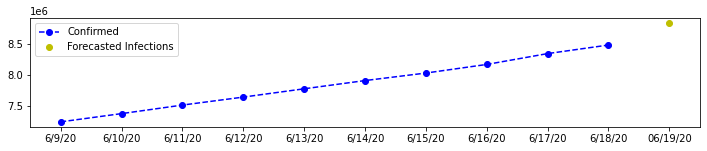

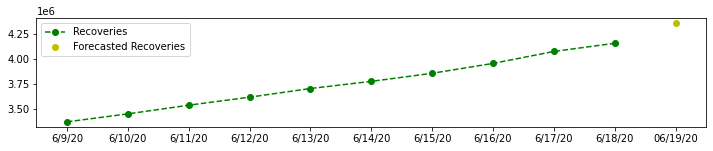

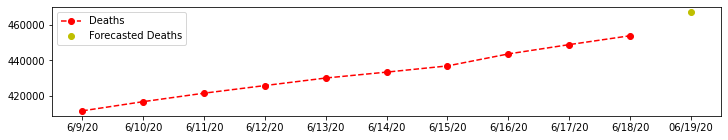

In [30]:
plt.figure(figsize=(12, 2))
plt.plot(df_conf[-10:], linestyle='--', marker='o', color='b', label='Confirmed')
plt.scatter(d1, fc_conf, color='y', label='Forecasted Infections')
plt.legend(loc="upper left")
plt.figure(figsize=(12, 2))
plt.plot(df_rec[-10:], linestyle='--', marker='o', color='g', label='Recoveries')
plt.scatter(d1, fc_rec, color='y', label='Forecasted Recoveries')
plt.legend(loc="upper left")
plt.figure(figsize=(12, 2))
plt.plot(df_dea[-10:], linestyle='--', marker='o', color='r', label='Deaths')
plt.scatter(d1, fc_dea, color='y', label='Forecasted Deaths')
plt.legend(loc="upper left")